# Unified Post-Processing in DeePTB

This tutorial demonstrates the usage of the unified post-processing interface in DeePTB. The new `TBSystem` class acts as a central hub for managing your tight-binding model and structure, providing streamlined access to properties like Band Structure and Density of States (DOS).

## key Features
- **Centralized Control**: `TBSystem` manages both the atomic structure (`AtomicData`) and the Hamiltonian model (`HamiltonianCalculator`).
- **Property Accessors**: Intuitive access to properties via `system.band`, `system.dos`, etc.
- **Flexible Configuration**: Stateful configuration for K-paths and K-meshes.
- **Integration**: Seamlessly works with DeePTB models and ASE structures.

## 1. Setup and Initialization

First, we define the paths to our model checkpoint (`.pth`) and the atomic structure file (e.g., `POSCAR` or `.vasp`).

In [1]:
import os
import numpy as  np
import torch
import matplotlib.pyplot as plt
from dptb.postprocess.unified.system import TBSystem

# Define paths (Adjust to your local environment)
root_dir = os.path.abspath("../ToW90_PythTB") 
model_path = os.path.join(root_dir, "models", "nnsk.ep20.pth")
struct_path = os.path.join(root_dir, "silicon.vasp")
model_non_north = "./nnsk.non_orth.pth"


TBPLaS is not installed. Thus the TBPLaS is not available, Please install it first.
Pybinding is not installed. Please install it via `pip install pybinding`


### Initialize TBSystem

We instantiate `TBSystem` by providing the data (structure) and the calculator (model). This automatically loads the model and prepares the system for calculation.

In [2]:
# Initialize the system with orthogonal and non-orthogonal TB models
tbsys = TBSystem(data=struct_path, calculator=model_path)
tbsys2 = TBSystem(data=struct_path, calculator=model_non_north)

print("TBSystem Initialized.")
# You can access the underlying ASE atoms object
print(f"Atoms: {tbsys.atoms}")
print(f"Atoms: {tbsys2.atoms}")

The model option atomic_radius in nnsk is not defined in input model_options, set to v1.


TBSystem Initialized.
Atoms: Atoms(symbols='Si2', pbc=True, cell=[[0.0, 2.71499984016137, 2.71499984016137], [2.71499984016137, 0.0, 2.71499984016137], [2.71499984016137, 2.71499984016137, 0.0]])
Atoms: Atoms(symbols='Si2', pbc=True, cell=[[0.0, 2.71499984016137, 2.71499984016137], [2.71499984016137, 0.0, 2.71499984016137], [2.71499984016137, 2.71499984016137, 0.0]])


In [3]:
tbsys.set_electrons({'Si':4})
tbsys.get_efermi(kmesh=[5,5,5])
tbsys2.set_electrons({'Si':4})
tbsys2.get_efermi(kmesh=[5,5,5])
print(f"Fermi Level (Orthogonal): {tbsys.efermi} eV")
print(f"Fermi Level (Non-Orthogonal): {tbsys2.efermi} eV")

/Users/aisiqg/Desktop/work/github/DeePTB/.venv/lib/python3.10/site-packages/torch/nested/__init__.py:107: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/NestedTensorImpl.cpp:180.)
  return torch._nested_tensor_from_tensor_list(ts, dtype, None, device, None)
eig_solver is not set, using default 'torch'.
eig_solver is not set, using default 'torch'.


Fermi Level (Orthogonal): -8.566754648927265 eV
Fermi Level (Non-Orthogonal): -4.143006716568811 eV


In [14]:
omegas = np.linspace(0, 6, 500)  # Frequency range from 0 to 10 eV
kmesh = [18, 18, 18]  # k-point mesh
broadening='lorentzian'

In [15]:
sigma = tbsys.accond.compute(
    omegas=omegas,
    kmesh=kmesh,
    broadening=broadening,
    direction='xx',
    temperature=300.0,
    eta=0.05,
    method='loop'
)

In [16]:
sigma2 = tbsys2.accond.compute(
    omegas=omegas,
    kmesh=kmesh,
    broadening=broadening,
    direction='xx',
    temperature=300.0,
    eta=0.05,
    method='loop'
)

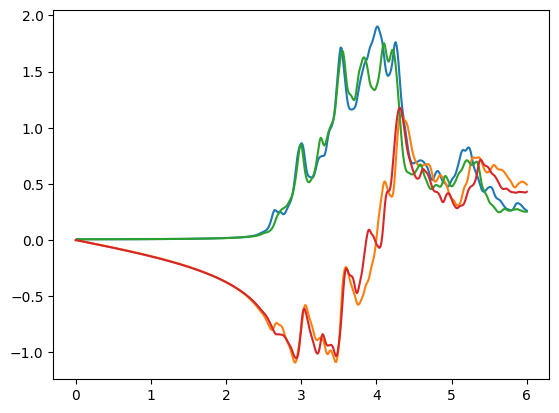

In [20]:
sigma.real
plt.plot(omegas, sigma.detach().numpy().real, label='Re[$\sigma_{xx}$]')
plt.plot(omegas, sigma.detach().numpy().imag, label='Im[$\sigma_{xx}$]')
plt.plot(omegas, sigma2.detach().numpy().real, label='Re[$\sigma_{xx}$]')
plt.plot(omegas, sigma2.detach().numpy().imag, label='Im[$\sigma_{xx}$]')


In [7]:
from tboptc.calc.optical_cond import AcCond
accondcal = AcCond(model=tbsys.model, results_path='./')
jdata={
    "task_options":{
        "task":"ac_cond",
        "emax": 6,
        "num_omega": 800,
        "mesh_grid": [18, 18, 18],
        "nk_per_loop": 32,
        "delta": 0.05,
        "e_fermi":-8.566754648927265,
        "valence_e": {"Si":4},
        "gap_corr": 0.0,
        "T": 300,
        "direction": "xx",
        "g_s": 2,
        "pbc":True
    }
}


In [8]:
accondcal.get_accond(struct=struct_path, 
                                pbc = jdata['task_options'].get('pbc',None),
                                emax=jdata['task_options'].get('emax'),
                                num_omega=jdata['task_options'].get('num_omega',1000),
                                mesh_grid=jdata['task_options'].get('mesh_grid',[1,1,1]),
                                nk_per_loop=jdata['task_options'].get('nk_per_loop',None),
                                delta=jdata['task_options'].get('delta',0.03),
                                e_fermi=jdata['task_options'].get('e_fermi',0),
                                valence_e=jdata['task_options'].get('valence_e',None),
                                gap_corr=jdata['task_options'].get('gap_corr',0),
                                T=jdata['task_options'].get('T',300),
                                direction=jdata['task_options'].get('direction','xx'),
                                g_s=jdata['task_options'].get('g_s',2)
                            )

    - numpy torch for diagonalization of H ...
    - numpy torch for diagonalization of H ...
    - numpy torch for diagonalization of H ...
    - numpy torch for diagonalization of H ...
    - numpy torch for diagonalization of H ...
    - numpy torch for diagonalization of H ...
    - numpy torch for diagonalization of H ...
    - numpy torch for diagonalization of H ...
    - numpy torch for diagonalization of H ...
    - numpy torch for diagonalization of H ...
    - numpy torch for diagonalization of H ...
    - numpy torch for diagonalization of H ...
    - numpy torch for diagonalization of H ...
    - numpy torch for diagonalization of H ...
    - numpy torch for diagonalization of H ...
    - numpy torch for diagonalization of H ...
    - numpy torch for diagonalization of H ...
    - numpy torch for diagonalization of H ...
    - numpy torch for diagonalization of H ...
    - numpy torch for diagonalization of H ...
    - numpy torch for diagonalization of H ...
    - numpy t

In [9]:
accondcal.omegas, accondcal.ac_cond_gauss, accondcal.ac_cond_linhard

(tensor([0.0000, 0.0075, 0.0150, 0.0225, 0.0300, 0.0375, 0.0451, 0.0526, 0.0601,
         0.0676, 0.0751, 0.0826, 0.0901, 0.0976, 0.1051, 0.1126, 0.1202, 0.1277,
         0.1352, 0.1427, 0.1502, 0.1577, 0.1652, 0.1727, 0.1802, 0.1877, 0.1952,
         0.2028, 0.2103, 0.2178, 0.2253, 0.2328, 0.2403, 0.2478, 0.2553, 0.2628,
         0.2703, 0.2778, 0.2854, 0.2929, 0.3004, 0.3079, 0.3154, 0.3229, 0.3304,
         0.3379, 0.3454, 0.3529, 0.3605, 0.3680, 0.3755, 0.3830, 0.3905, 0.3980,
         0.4055, 0.4130, 0.4205, 0.4280, 0.4355, 0.4431, 0.4506, 0.4581, 0.4656,
         0.4731, 0.4806, 0.4881, 0.4956, 0.5031, 0.5106, 0.5181, 0.5257, 0.5332,
         0.5407, 0.5482, 0.5557, 0.5632, 0.5707, 0.5782, 0.5857, 0.5932, 0.6008,
         0.6083, 0.6158, 0.6233, 0.6308, 0.6383, 0.6458, 0.6533, 0.6608, 0.6683,
         0.6758, 0.6834, 0.6909, 0.6984, 0.7059, 0.7134, 0.7209, 0.7284, 0.7359,
         0.7434, 0.7509, 0.7584, 0.7660, 0.7735, 0.7810, 0.7885, 0.7960, 0.8035,
         0.8110, 0.8185, 0.8

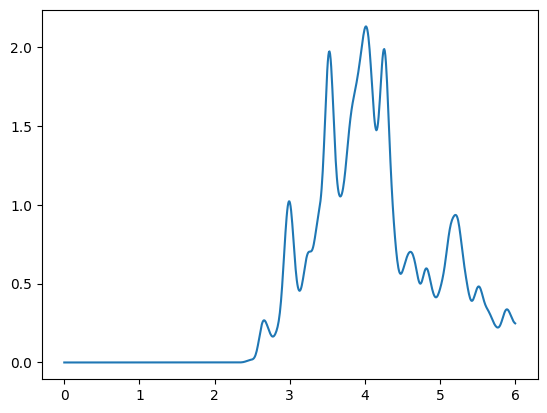

In [10]:
accondcal.omegas
plt.plot(accondcal.omegas, accondcal.ac_cond_gauss.real, label='Re[$\sigma_{xx}$]')

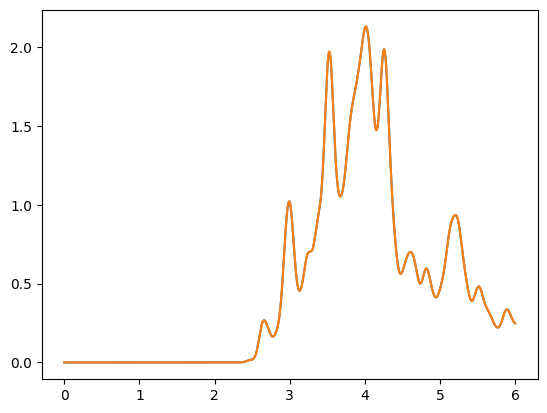

In [11]:
sigma.real
plt.plot(omegas, sigma.detach().numpy().real, label='Re[$\sigma_{xx}$]')
plt.plot(accondcal.omegas, accondcal.ac_cond_gauss.real, label='Re[$\sigma_{xx}$]')
#plt.plot(omegas, sigma.detach().numpy().imag, label='Re[$\sigma_{xx}$]')

In [ ]:
sigma.real
plt.plot(omegas, sigma.detach().numpy().real, label='Re[$\sigma_{xx}$]')
plt.plot(accondcal.omegas, accondcal.ac_cond_gauss.real, label='Re[$\sigma_{xx}$]')
#plt.plot(omegas, sigma.detach().numpy().imag, label='Re[$\sigma_{xx}$]')